In [17]:
import pandas as pd
import numpy as np
from gensim.models import LdaModel, LdaMulticore
from gensim import corpora
from tqdm import tqdm, trange

import string
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [3]:
data = pd.read_csv('data/data.csv')
data.head()

,FidelityLevel,Phrase
0,High fidelity,important the relationship between mental and ...
1,High fidelity,problems with their physical health and psycho...
2,High fidelity,stress impacts our health
3,High fidelity,understand how mental and physical health cond...
4,High fidelity,get what you want out of life.


In [4]:
documents = list(data['Phrase'])

In [8]:
def remove_punctuation(text):
    text = str(text)
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree

def tokenization(text):
    return word_tokenize(text)

stopwords = nltk.corpus.stopwords.words('english')
def remove_stopwords(text):
    output= [i for i in text if i not in stopwords]
    return output

porter_stemmer = PorterStemmer()
def stemming(text):
    stem_text = [porter_stemmer.stem(word) for word in text]
    return stem_text

wordnet_lemmatizer = WordNetLemmatizer()
def lemmatizer(text):
    lemm_text = [wordnet_lemmatizer.lemmatize(word) for word in text]
    return lemm_text

In [9]:
data['Phrase']= data['Phrase'].apply(lambda x:remove_punctuation(x))
data['Phrase']= data['Phrase'].apply(lambda x: x.lower())
data['Phrase']= data['Phrase'].apply(lambda x: tokenization(x))
data['Phrase']= data['Phrase'].apply(lambda x:remove_stopwords(x))
data['Phrase']= data['Phrase'].apply(lambda x: stemming(x))
data['Phrase']= data['Phrase'].apply(lambda x:lemmatizer(x))

In [10]:
data.head()

,FidelityLevel,Phrase
0,High fidelity,"[import, relationship, mental, physic, health]"
1,High fidelity,"[problem, physic, health, psycholog, wellb, ac..."
2,High fidelity,"[stress, impact, health]"
3,High fidelity,"[understand, mental, physic, health, condit, d..."
4,High fidelity,"[get, want, life]"


In [12]:
doc_tokens = list(data['Phrase'])

In [13]:
id2word = corpora.Dictionary(doc_tokens)

In [14]:
corpus = [id2word.doc2bow(text) for text in doc_tokens]

In [15]:
from gensim.models import CoherenceModel
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3): 
    """
    Compute c_v coherence for various number of topics
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics
    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respect """
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=id2word, iterations=600, passes=2) 
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
#        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [18]:
topic_count_start = 2
topic_count_step = 1
topic_count_limit = 10
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, texts=None, 
                                                        limit=topic_count_limit, 
                                                        start=topic_count_start, 
                                                        step=topic_count_step)
#  compute_coherence_values(dictionary=id2word, corpus=corpus, texts=doc_tokens, limit=topic_count_limit, start=topic_count_start, step=topic_count_step)

100%|██████████| 8/8 [00:11<00:00,  1.44s/it]


In [19]:
coherence_values

[-10.498694774162054,
 -12.023528295421942,
 -12.70111201396885,
 -13.953375358473764,
 -13.571155873009948,
 -14.760390660297967,
 -14.348811259018099,
 -14.990677620995292]

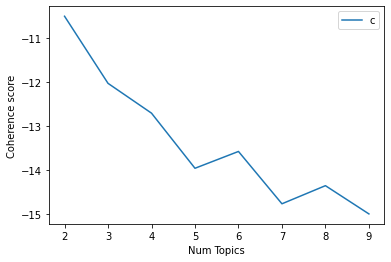

In [21]:
import matplotlib.pyplot as plt 
%matplotlib inline
# Show graph
x = range(topic_count_start, topic_count_limit, topic_count_step)
plt.plot(x, coherence_values) 
plt.xlabel("Num Topics") 
plt.ylabel("Coherence score") 
plt.legend(("coherence_values"), loc='best') 
plt.show()

In [22]:
topic_idx = np.argmax(coherence_values)
print(coherence_values[topic_idx]) 
test_lda = model_list[topic_idx]

-10.498694774162054


In [23]:
test_lda.num_topics

2

In [24]:
n_topics = test_lda.num_topics
col_names = []
for x in range(n_topics):
    topic_name = f"Topic{x+1}"
    col_names.append((topic_name, "Word"))
    col_names.append((topic_name, "Weight"))

In [25]:
tw_df = pd.DataFrame()

In [26]:
data = []
for x in range(n_topics):
    top_words = test_lda.show_topic(x, 20)
    words = []
    weights = []
    for word_weight in top_words:
        words.append(word_weight[0])
        weights.append(word_weight[1])
    data.append(words)
    data.append(weights)
    tw_df[f"Word{x+1}"] = words
    tw_df[f"Weight{x+1}"] = weights   

In [27]:
tw_df.columns = pd.MultiIndex.from_tuples(col_names)

In [28]:
tw_df

Topic1             Topic2          
      Word    Weight     Word    Weight
0     feel  0.021762     help  0.021512
1     like  0.019728      get  0.017198
2      tri  0.017818     dont  0.015505
3       im  0.015416     feel  0.010559
4       go  0.013368     that  0.008865
5    thing  0.009282     hard  0.007967
6     good  0.007421     life  0.007876
7     work  0.007287     want  0.007650
8   realli  0.007150     make  0.007536
9     yeah  0.007138     need  0.007092
10   think  0.007105    peopl  0.006811
11    take  0.007041    think  0.006778
12    help  0.006093  anxieti  0.006505
13     one  0.006078     know  0.006413
14     way  0.006029     like  0.006008
15    much  0.005981     your  0.005701
16    your  0.005917     cant  0.005466
17  stress  0.005769    would  0.005444
18  better  0.005678      lot  0.005404
19    find  0.005508   person  0.004946